In [8]:
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_histogram
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel
from qiskit_aer.noise.errors import pauli_error, depolarizing_error
import matplotlib.pyplot as plt

import qiskit, numpy as np
print("Qiskit:", qiskit.__version__)

Qiskit: 2.1.1


In [9]:
def repetition_encode(bit=0):
    """Encodes |0>->|000>, |1>->|111>."""
    qc = QuantumCircuit(3)  # 3 qubits
    if bit == 1:
        qc.x(0)                 # flip the first qubit to |1>
    qc.cx(0,1)                  # copy qubit 0 to qubit 1
    qc.cx(0,2)                  # copy qubit 0 to qubit 2
    return qc

def repetition_measure():
    """
    Measure all 3 qubits into 3 classical bits.
    """
    qc = QuantumCircuit(3, 3)
    qc.measure([0,1,2], [0,1,2])
    return qc

In [10]:
def bitflip_noise_model(p1=0.05, p2=None):
    """
    p1: 1-qubit X-flip probability for 1-qubit ops
    p2: 2-qubit X-type Pauli probability on CX (defaults to ~2*p1/3)
    """
    if p2 is None:
        p2 = 2*p1/3

    nm = NoiseModel()

    # 1-qubit X channel
    x_err_1q = pauli_error([('X', p1), ('I', 1-p1)])
    nm.add_all_qubit_quantum_error(x_err_1q, ['id', 'x', 'sx'])

    # 2-qubit X-only Pauli channel on CX (IX, XI, XX)
    cx_err_2q = pauli_error([
        ('II', 1 - p2),
        ('IX',  p2/3),
        ('XI',  p2/3),
        ('XX',  p2/3),
    ])
    nm.add_all_qubit_quantum_error(cx_err_2q, ['cx'])

    return nm

In [11]:
def depol_noise_model(p1=0.01, p2=None):
    """
    p1: 1-qubit depolarising probability
    p2: 2-qubit depolarising probability on CX (defaults to 2*p1)
    """
    if p2 is None:
        p2 = 2*p1

    nm = NoiseModel()
    nm.add_all_qubit_quantum_error(depolarizing_error(p1, 1), ['id','x','sx','h'])
    nm.add_all_qubit_quantum_error(depolarizing_error(p2, 2), ['cx'])
    return nm

Decoded logical accuracy: 0.9267


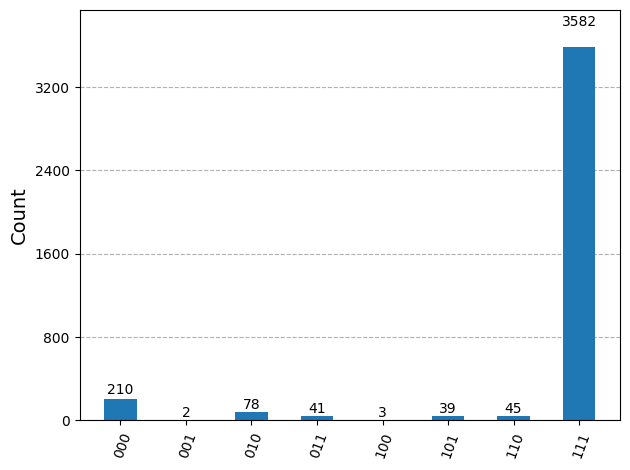

In [12]:
def build_full_circuit(logical_bit=1):
    base = QuantumCircuit(3, 3)
    base = base.compose(repetition_encode(logical_bit), qubits=[0,1,2])
    base.barrier()
    base = base.compose(repetition_measure(), qubits=[0,1,2], clbits=[0,1,2])
    return base

def majority_vote_from_counts(counts, logical_bit):
    """
    counts: dict like {'000': n0, '001': n1, ...}
    return: accuracy of decoding by majority vote
    """
    ok = 0
    total = 0
    target = logical_bit
    for bitstr, n in counts.items():
        # bitstr is e.g. '010' with c0=0,c1=1,c2=0; majority of chars
        votes = [int(b) for b in bitstr]
        pred = 1 if sum(votes) >= 2 else 0
        ok += (pred == target) * n
        total += n
    return ok / max(total, 1)

# pick noise model
noise = bitflip_noise_model(p1=0.05)   # or: depol_noise_model(0.02)

sim = AerSimulator()
basis = ['id','rz','sx','x','cx','measure']   # typical basis for Aer
qc_full = build_full_circuit(logical_bit=1)
tc = transpile(qc_full, sim, basis_gates=basis, optimization_level=1)

res = sim.run(tc, shots=4000, noise_model=noise).result()
counts = res.get_counts()
acc = majority_vote_from_counts(counts, logical_bit=1)

print("Decoded logical accuracy:", round(acc, 4))
plot_histogram(counts)

c:\Users\86182\AppData\Local\Programs\Python\Python313\Lib\site-packages\qiskit\compiler\transpiler.py:269: UserWarning: Providing `coupling_map` and/or `basis_gates` along with `backend` is not recommended, as this will invalidate the backend's gate durations and error rates.
  pm = generate_preset_pass_manager(


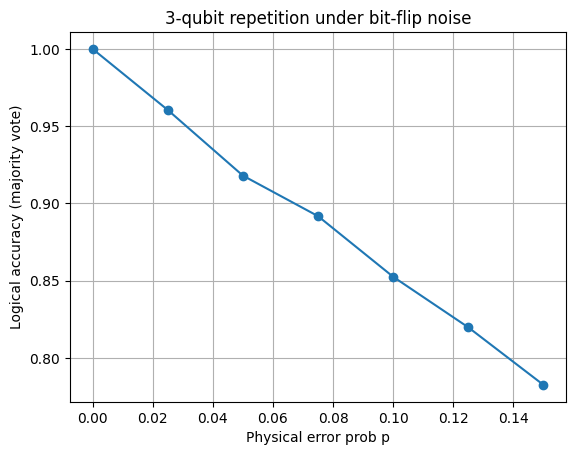

In [13]:
ps = np.linspace(0.0, 0.15, 7)
accs = []
for p in ps:
    noise = bitflip_noise_model(p1=p)  # or: depol_noise_model(p)
    tc = transpile(build_full_circuit(1), sim, basis_gates=basis, optimization_level=1)
    res = sim.run(tc, shots=4000, noise_model=noise).result()
    accs.append( majority_vote_from_counts(res.get_counts(), 1) )

plt.plot(ps, accs, marker='o')
plt.xlabel("Physical error prob p")
plt.ylabel("Logical accuracy (majority vote)")
plt.title("3-qubit repetition under bit-flip noise")
plt.grid(True)
plt.show()